#### HOTELS ATTRIBUTES EXTRACTION PROCESS

This notebook was used to execute manually the scripts to scrape all of the previously scrapped hotels attributes.

From the scrapping.py file we import scrape_hotels_attributes, this function takes a list of urls and returns a dataframe with the following hotel data:

- attributes
- scores

The data was scrapped from the [Booking.com](https://www.booking.com/index.es.html?label=gen173nr-1BCAEoggI46AdIM1gEaAyIAQGYAQq4ARfIAQzYAQHoAQGIAgGoAgO4At_puqsGwAIB0gIkOTkxOTFjMmEtNTEzYS00NDQyLTgxNmMtMWJmMzMyYzVjNjJj2AIF4AIB&sid=1a3dea14733e69dc474ff74d1fad21e9&keep_landing=1&sb_price_type=total&) web, from a page like this: [boooking/hotels/newyork/hotel.com](https://www.booking.com/hotel/us/west-side-ymca.es.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaAyIAQGYAQq4ARfIAQzYAQHoAQH4AQyIAgGoAgO4Arj9uqsGwAIB0gIkMzNmMDQ2ZDMtOTkwYy00ZWVmLTgwZDYtYzhjMWUxZmFjM2Yz2AIG4AIB&sid=75f60e0ba4b489f2fe2baf48281729c2&dest_id=20088325;dest_type=city;dist=0;group_adults=2;group_children=0;hapos=4;hpos=4;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;srepoch=1701756621;srpvid=525f2b61586300dd;type=total;ucfs=1&#hotelTmpl).

In [6]:
import sys
import scrapping
import pandas as pd

sys.path.append('../lib')
import personalised_graphics

usa_cities = pd.read_csv("../data/usa_cities.csv")
usa_states = pd.read_csv("../data/usa_states.csv")

# This functions takes a state_id and executes the scrapping process
def scrape(state_id: list):
    state = state=usa_states["state"][usa_states["state_id"] == state_id].iloc[0]
    hotels = pd.read_csv(f"../data/booking/{state}_hotels.csv")
    hotels_attributes = scrapping.scrape_hotels_attributes(hotels["reviews_url"].tolist())
    personalised_graphics.missing_values_heatmap(hotels_attributes, f"{state}_hotels_attributes scrape result") # explore data
    return hotels_attributes

'def scrape(state_id: list):\n    newyork_cities = usa_cities[(usa_cities["state_id"] == state_id)].sort_values(by="population", ascending=False).head(10) # filtrate top 10 populated cities\n    newyork_hotels = scrapping.scrape_cities_hotels(newyork_cities["city"].to_list(), state="NewYork", interfase=True) # scrapear hoteles\n    personalised_graphics.missing_values_heatmap(newyork_hotels) # explore data\n    newyork_hotels # explore data'

California

1/1546
2/1546
3/1546
4/1546
5/1546
6/1546
7/1546
8/1546
9/1546
10/1546
11/1546
12/1546
13/1546
14/1546
15/1546
16/1546
17/1546
18/1546
19/1546
20/1546
21/1546
22/1546
23/1546
24/1546
25/1546
26/1546
27/1546
28/1546
29/1546
30/1546
31/1546
32/1546
33/1546
34/1546
35/1546
36/1546
37/1546
38/1546
39/1546
40/1546
41/1546
42/1546
43/1546
44/1546
45/1546
46/1546
47/1546
48/1546
49/1546
50/1546
51/1546
52/1546
53/1546
54/1546
55/1546
56/1546
57/1546
58/1546
59/1546
60/1546
61/1546
62/1546
63/1546
64/1546
65/1546
66/1546
67/1546
68/1546
69/1546
70/1546
71/1546
72/1546
73/1546
74/1546
75/1546
76/1546
77/1546
78/1546
79/1546
80/1546
81/1546
82/1546
83/1546
84/1546
85/1546
86/1546
87/1546
88/1546
89/1546
90/1546
91/1546
92/1546
93/1546
94/1546
95/1546
96/1546
97/1546
98/1546
99/1546
100/1546
101/1546
102/1546
103/1546
104/1546
105/1546
106/1546
107/1546
108/1546
109/1546
110/1546
111/1546
112/1546
113/1546
114/1546
115/1546
116/1546
117/1546
118/1546
119/1546
120/1546
121/1546
122/1546
123/1546
1

FileNotFoundError: [Errno 2] No such file or directory: 'gallery/cailornia_hotels_attributes scrape result.png'

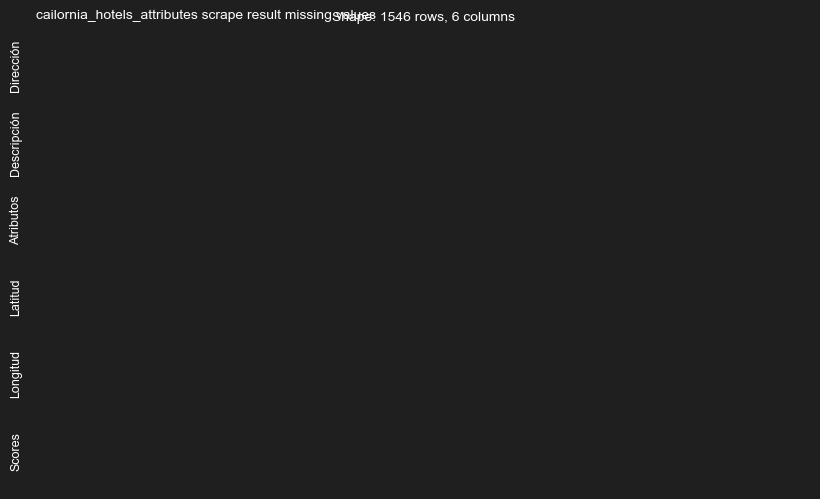

In [11]:
california_hotels = pd.read_csv("../data/booking/california_hotels.csv")
hotels_attributes = scrapping.scrape_hotels_attributes(california_hotels["reviews_url"].tolist())
personalised_graphics.missing_values_heatmap(hotels_attributes, f"cailornia_hotels_attributes scrape result") # explore data
hotels_attributes.to_csv("../data/booking/california_hotels_attributes.csv")